## Understanding and Predicting Property Maintenance Fines

This is a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/).

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

### Files Import & Primary exploration

In [292]:
#Detect encoding of csv file
import chardet
# look at the first ten thousand bytes to guess the character encoding
with open('readonly/train.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))
# check what the character encoding might be
print(result)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [293]:
df = pd.read_csv('readonly/train.csv',engine='python')
# Remove "not responsible" compliance target
df = df[df['compliance'].isnull()==False]

In [294]:
df.shape

(159880, 34)

In [ ]:
#Set ticket_id as index
df.set_index('ticket_id',drop=True,inplace=True)

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 22056 to 284333
Data columns (total 33 columns):
agency_name                   159880 non-null object
inspector_name                159880 non-null object
violator_name                 159854 non-null object
violation_street_number       159880 non-null float64
violation_street_name         159880 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    157322 non-null float64
mailing_address_str_name      159877 non-null object
city                          159880 non-null object
state                         159796 non-null object
zip_code                      159879 non-null object
non_us_str_code               3 non-null object
country                       159880 non-null object
ticket_issued_date            159880 non-null object
hearing_date                  159653 non-null object
violation_code                159880 non-null object
violation_description         159880 non-nul

In [297]:
df.describe()

,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
count,1.598800e+05,0.0,1.573220e+05,159880.000000,159880.0,159880.0,159880.000000,159880.000000,159880.0,159880.000000,159880.000000,159880.000000,159880.000000
mean,1.071316e+04,NaN,9.133714e+03,357.035295,20.0,10.0,33.651512,0.195959,0.0,420.650218,72.206537,348.263284,0.072536
std,3.623159e+04,NaN,3.657729e+04,675.655580,0.0,0.0,67.692916,4.290344,0.0,742.555062,259.849545,729.295700,0.259374
min,0.000000e+00,NaN,1.000000e+00,0.000000,20.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,-7750.000000,0.000000
25%,4.920000e+03,NaN,5.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,85.000000,0.000000
50%,1.039800e+04,NaN,2.418000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
75%,1.578325e+04,NaN,1.284400e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
max,1.415411e+07,NaN,5.111345e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000


### Data Exploration: Null Variables

In [298]:
#Find columns with null/missing data
df.isnull().sum(axis=0)

agency_name                        0
inspector_name                     0
violator_name                     26
violation_street_number            0
violation_street_name              0
violation_zip_code            159880
mailing_address_str_number      2558
mailing_address_str_name           3
city                               0
state                             84
zip_code                           1
non_us_str_code               159877
country                            0
ticket_issued_date                 0
hearing_date                     227
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        0
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
payment_amount                     0
balance_due                        0
p

In [299]:
# Exclude following columns due to large missing data or data leakage issue for data unvailable at the time of future training
exclusion_list = ['non_us_str_code'
                  ,'violation_zip_code'
                  ,'payment_amount'
                  ,'balance_due'
                  ,'payment_date'
                  ,'payment_status'
                  ,'collection_status'
                  ,'compliance_detail'
                  ,'admin_fee'
                  ,'state_fee'
                  ,'late_fee'
                  ,'discount_amount'
                  ,'violation_street_number'
                  ,'mailing_address_str_number'
                  ,'judgment_amount'
                  ,'violation_street_name'
                  ,'clean_up_cost'
                  ,'grafitti_status']
df.drop(labels=exclusion_list,axis=1,inplace=True)

### Data Exploration: Categorical Variables

In [300]:
# Check cardinality of object features
object_columns = df.select_dtypes(include=[object]).columns.values.tolist()

for col in object_columns:
    elements = df[col].unique().tolist()
    print(col,' : ', len(elements))  
    if len(elements) < 10:
        print(*elements, sep='\n')
    print('\n')

agency_name  :  5
Buildings, Safety Engineering & Env Department
Health Department
Department of Public Works
Detroit Police Department
Neighborhood City Halls


inspector_name  :  159


violator_name  :  84657


mailing_address_str_name  :  28441


city  :  4093


state  :  60


zip_code  :  3499


country  :  5
USA
Cana
Aust
Egyp
Germ


ticket_issued_date  :  68097


hearing_date  :  5971


violation_code  :  189


violation_description  :  207


disposition  :  4
Responsible by Default
Responsible by Determination
Responsible by Admission
Responsible (Fine Waived) by Deter




In [301]:
# Exclude following object columns due to high cardinality or double information (state&zipcode)
exclusion_list = ['inspector_name'
                  ,'violator_name'
                  ,'violation_description'
                  ,'mailing_address_str_name'
                  ,'city'
                  ,'state']
df.drop(labels=exclusion_list,axis=1,inplace=True)

In [302]:
# Frequency of unique categorical values
for col in ['agency_name','violation_code','disposition','zip_code']:
    temp = df.groupby(col).size().sort_values(ascending=False)
    print(np.sum(temp))
    print(temp,'\n')

159880
agency_name
Buildings, Safety Engineering & Env Department    95863
Department of Public Works                        52445
Health Department                                  7107
Detroit Police Department                          4464
Neighborhood City Halls                               1
dtype: int64 

159880
violation_code
9-1-36(a)               64414
9-1-81(a)               23145
22-2-88                 19073
9-1-104                 16927
22-2-88(b)               4879
22-2-45                  4200
9-1-105                  3619
9-1-110(a)               3147
9-1-43(a) - (Dwellin     3043
9-1-103(C)               2641
22-2-22                  2612
22-2-43                  2054
19450901                 1620
22-2-17                  1414
22-2-61                   706
22-2-83(a)(b)(c)          494
9-1-82(d) - (Dwellin      457
61-81.0100/32.0066        439
9-1-43(a) - (Structu      399
22-2-83                   347
22-2-88(a)                235
9-1-206                   235
61-5

### FEATURE EXTRACTION: Categorial variables

- country: split by USA & others then hot encoder
- date diff between ticket_issued and hearing_date then classify in 2 groups & hot encoder
- violation_code: pick x first one, overwrite others withs others & hot encoder
- extract weekday from ticket issued date & hot encoder
- extract info from zipcode & hot encoder
- hot encoder for agency_name & disposition

In [303]:
#Feature extraction: AGENCY
df['agency_name'] = df['agency_name'].apply(lambda x: x if x in ['Buildings, Safety Engineering & Env Department','Department of Public Works'] else 'Others') 

In [304]:
#Feature extraction: DISPOSITION
df['disposition'] = df['disposition'].apply(lambda x: x if x in ['Responsible by Default','Responsible by Admission'] else 'Others') 

In [305]:
#Feature extraction: COUNTRY
df['country'] = df['country'].apply(lambda x: x if x in ['USA'] else 'Others') 

In [306]:
#Feature extraction: VIOLATION_CODE
df['violation_code'] = df['violation_code'].apply(lambda x: x[:4] if x[:4] in ['9-1-','22-2'] else 'Others') 

In [307]:
#Feature extraction: ZIP_CODE
df['zip_code'] = df['zip_code'].astype('str').apply(lambda x: x[:3] if x[:3] in ['480','481','482','483'] else 'Others') 

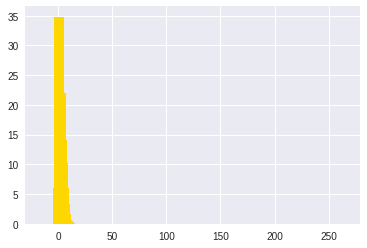

In [308]:
#Feature extraction: Date diff grouping between ticket_issued and hearing_date

from datetime import datetime
#Convert datetime to date
df['ticket_issued_date'] = pd.to_datetime(df['ticket_issued_date'], format='%Y-%m-%d')
df['hearing_date'] = pd.to_datetime(df['hearing_date'], format='%Y-%m-%d')
#Calculate Month_between
df['Month_Between'] = df['hearing_date'].dt.to_period('M') - df['ticket_issued_date'].dt.to_period('M')
df['Month_Between'] = df['Month_Between'].astype(int)
#Visualize frequency of each class
x = sorted(df.groupby('Month_Between').size().index)

total = len(df['Month_Between'] )
MB = pd.DataFrame(df.groupby('Month_Between').size())
MB['%'] = (MB[0]/total)*100
#MB['%']
values = MB['%'].values

plt.bar(x,values,color='gold',width=10)

#Create grouping based on frequency
def month_grouping(row):
    if row >= 0 and row <= 1:
        return 1
    elif row >= 2 and row <= 3:
        return 2
    elif row > 3:
        return 3
    else:
        return 0
df['Month_Between_Grouping'] = df['Month_Between'].apply(lambda x: month_grouping(x))
df.drop(labels=['Month_Between','hearing_date'],axis=1,inplace=True)

In [309]:
#Feature extraction: Weekday
df['week_day'] = pd.to_datetime(df['ticket_issued_date']).dt.dayofweek
df.drop(labels=['ticket_issued_date'],axis=1,inplace=True)

In [310]:
df.columns

Index(['agency_name', 'zip_code', 'country', 'violation_code', 'disposition',
       'fine_amount', 'compliance', 'Month_Between_Grouping', 'week_day'],
      dtype='object')

### Encode categorical variables

In [311]:
# hot encoder list
hot_encoder_list = ['agency_name','disposition','Month_Between_Grouping','violation_code','week_day','zip_code']
final = df.copy(deep=True)

for col in hot_encoder_list:
    temp = pd.get_dummies(final[col], prefix=col).iloc[:,:-1]
    final=pd.concat([final,temp],axis=1)

count = pd.get_dummies(final['country'], prefix='country')
final=pd.concat([final,count],axis=1)

final.drop(labels=['agency_name','disposition','country','country_Others','Month_Between_Grouping','violation_code','week_day','zip_code'], axis=1, inplace=True)

In [312]:
final.columns

Index(['fine_amount', 'compliance',
       'agency_name_Buildings, Safety Engineering & Env Department',
       'agency_name_Department of Public Works', 'disposition_Others',
       'disposition_Responsible by Admission', 'Month_Between_Grouping_0',
       'Month_Between_Grouping_1', 'Month_Between_Grouping_2',
       'violation_code_22-2', 'violation_code_9-1-', 'week_day_0',
       'week_day_1', 'week_day_2', 'week_day_3', 'week_day_4', 'week_day_5',
       'zip_code_480', 'zip_code_481', 'zip_code_482', 'zip_code_483',
       'country_USA'],
      dtype='object')

### Create final training dataset

In [313]:
y_train = final['compliance']
X_train = final.drop(labels=['compliance'], axis=1)

In [314]:
print(y_train.shape)
print(X_train.shape)

(159880,)
(159880, 21)


In [315]:
X_train.columns

Index(['fine_amount',
       'agency_name_Buildings, Safety Engineering & Env Department',
       'agency_name_Department of Public Works', 'disposition_Others',
       'disposition_Responsible by Admission', 'Month_Between_Grouping_0',
       'Month_Between_Grouping_1', 'Month_Between_Grouping_2',
       'violation_code_22-2', 'violation_code_9-1-', 'week_day_0',
       'week_day_1', 'week_day_2', 'week_day_3', 'week_day_4', 'week_day_5',
       'zip_code_480', 'zip_code_481', 'zip_code_482', 'zip_code_483',
       'country_USA'],
      dtype='object')

In [316]:
#X_train

# Hyperparameters tuning

In [317]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state = 0)

parameters = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth":[2,3,5],
    "n_estimators":[50,100]
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(random_state = 0), parameters,scoring='roc_auc',cv=3, n_jobs=-1,verbose=3)

In [318]:
clf.fit(X_train, y_train)
clf.cv_results_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] learning_rate=0.01, max_depth=2, n_estimators=50 ................
[CV] learning_rate=0.01, max_depth=2, n_estimators=50 ................
[CV] learning_rate=0.01, max_depth=2, n_estimators=50 ................
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=3, n_estimators=50 ................
[CV] learning_rate=0.01, max_depth=3, n_estimators=50 ................
[CV] learning_rate=0.01, max_depth=3, n_estimators=50 ................
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=5, n_estimators=50 ................
[CV] learning_ra

[Parallel(n_jobs=-1)]: Done  10 out of  54 | elapsed:  3.5min remaining: 15.4min


[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, score=0.732478, total= 4.0min
[CV] learning_rate=0.1, max_depth=3, n_estimators=50 .................
[CV]  learning_rate=0.05, max_depth=3, n_estimators=50, score=0.779006, total= 3.7min
[CV]  learning_rate=0.05, max_depth=3, n_estimators=50, score=0.774653, total= 3.7min
[CV] learning_rate=0.1, max_depth=3, n_estimators=50 .................
[CV] learning_rate=0.1, max_depth=3, n_estimators=50 .................
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, score=0.725196, total= 4.4min
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................
[CV]  learning_rate=0.05, max_depth=3, n_estimators=50, score=0.774577, total= 4.3min
[CV]  learning_rate=0.1, max_depth=2, n_estimators=50, score=0.772943, total= 2.0min
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ...

[Parallel(n_jobs=-1)]: Done  29 out of  54 | elapsed:  8.1min remaining:  7.0min


[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, score=0.780747, total= 4.3min
[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, score=0.782749, total= 3.6min
[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, score=0.777200, total= 3.8min
[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, score=0.777441, total= 7.4min
[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, score=0.782763, total= 7.2min
[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, score=0.788674, total= 3.8min
[CV]  learning_rate=0.05, max_depth=5, n_estimators=50, score=0.777716, total= 7.3min
[CV]  learning_rate=0.01, max_depth=5, n_estimators=50, score=0.776818, total= 8.2min
[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=0.790507, total= 4.0min
[CV]  learning_rate=0.05, max_depth=5, n_estimators=50, score=0.783730, total= 7.6min
[CV]  learning_rate=0.05, max_depth=5, n_estimators=50, score=0.788682, total= 8.3min
[CV]  learning_rate=0.1, max_depth=3, n_estimators=100,

[Parallel(n_jobs=-1)]: Done  48 out of  54 | elapsed: 11.1min remaining:  1.4min


[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, score=0.785102, total= 8.7min
[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, score=0.780290, total= 9.2min
[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, score=0.790621, total= 8.9min
[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=0.791627, total= 5.3min
[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=0.787068, total= 4.1min
[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=0.780575, total= 6.0min


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 11.6min finished


{'mean_fit_time': array([ 110.98916316,  223.42722178,  184.860207  ,  440.66880894,
         452.23574583,  635.23335989,  134.70220955,  268.10082428,
         226.30331739,  423.00005825,  460.06715091,  534.53850484,
         141.13705134,  260.37004709,  221.26816742,  277.93649324,
         320.00431808,  306.6770486 ]),
 'mean_score_time': array([ 1.69785206,  5.16553871,  2.30015683,  5.63143134,  5.36793963,
         1.46671931,  2.00010562,  2.73384118,  5.99882619,  2.96894177,
         2.60119128,  0.89744059,  1.69969678,  2.46781643,  2.7702148 ,
         1.46847049,  1.49680813,  0.42867835]),
 'mean_test_score': array([ 0.72720544,  0.72803603,  0.76526424,  0.76582661,  0.77716087,
         0.78138331,  0.76865937,  0.77669515,  0.77607853,  0.78335576,
         0.78337604,  0.78533762,  0.7767576 ,  0.77948571,  0.78287432,
         0.78518865,  0.78529277,  0.78642315]),
 'mean_train_score': array([ 0.72720633,  0.7280423 ,  0.76546571,  0.76613745,  0.77828216,
    

In [319]:
print(clf.best_params_)
print(clf.best_score_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
0.786423153468


### Train Model

      Iter       Train Loss   Remaining Time 
         1           0.4907           30.93s
         2           0.4749           32.91s
         3           0.4636           31.54s
         4           0.4553           30.81s
         5           0.4490           30.32s
         6           0.4440           29.94s
         7           0.4399           30.17s
         8           0.4366           29.66s
         9           0.4340           29.17s
        10           0.4318           28.78s
        20           0.4220           26.73s
        30           0.4194           22.60s
        40           0.4181           18.57s
        50           0.4171           15.37s
        60           0.4164           12.05s
        70           0.4158            9.13s
        80           0.4152            6.13s
        90           0.4147            3.06s
       100           0.4143            0.00s


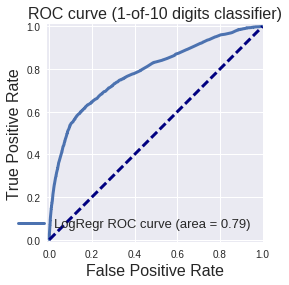

In [320]:
clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,n_estimators=100,random_state = 0,verbose=1)
clf = clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Feature extraction: Test data

In [340]:
def feature_extraction(dataset):
    df = dataset.copy(deep=True)
    df.set_index('ticket_id',drop=True,inplace=True)
    
    # Exclude following columns due to large missing data or data leakage issue for data unvailable at the time of future training
    exclusion_list = ['non_us_str_code'
                      ,'violation_zip_code'
                      ,'admin_fee'
                      ,'state_fee'
                      ,'late_fee'
                      ,'discount_amount'
                      ,'violation_street_number'
                      ,'mailing_address_str_number'
                      ,'judgment_amount'
                      ,'violation_street_name'
                      ,'clean_up_cost'
                      ,'grafitti_status']
    df.drop(labels=exclusion_list,axis=1,inplace=True)
    
    # Exclude following object columns due to high cardinality or double information (state&zipcode)
    exclusion_list = ['inspector_name'
                      ,'violator_name'
                      ,'violation_description'
                      ,'mailing_address_str_name'
                      ,'city'
                      ,'state']
    df.drop(labels=exclusion_list,axis=1,inplace=True)
    
    #Feature extraction: AGENCY
    df['agency_name'] = df['agency_name'].apply(lambda x: x if x in ['Buildings, Safety Engineering & Env Department','Department of Public Works'] else 'Others') 
    
    #Feature extraction: DISPOSITION
    df['disposition'] = df['disposition'].apply(lambda x: x if x in ['Responsible by Default','Responsible by Admission'] else 'Others') 
    
    #Feature extraction: COUNTRY
    df['country'] = df['country'].apply(lambda x: x if x in ['USA'] else 'Others') 

    #Feature extraction: VIOLATION_CODE
    df['violation_code'] = df['violation_code'].apply(lambda x: x[:4] if x[:4] in ['9-1-','22-2'] else 'Others') 
    
    #Feature extraction: ZIP_CODE
    df['zip_code'] = df['zip_code'].astype('str').apply(lambda x: x[:3] if x[:3] in ['480','481','482','483'] else 'Others') 
    
    from datetime import datetime
    #Convert datetime to date
    df['ticket_issued_date'] = pd.to_datetime(df['ticket_issued_date'], format='%Y-%m-%d')
    df['hearing_date'] = pd.to_datetime(df['hearing_date'], format='%Y-%m-%d')
    #Calculate Month_between
    df['Month_Between'] = df['hearing_date'].dt.to_period('M') - df['ticket_issued_date'].dt.to_period('M')
    df['Month_Between'] = df['Month_Between'].astype(int)
    #Create grouping based on frequency
    def month_grouping(row):
        if row >= 0 and row <= 1:
            return 1
        elif row >= 2 and row <= 3:
            return 2
        elif row > 3:
            return 3
        else:
            return 0
    df['Month_Between_Grouping'] = df['Month_Between'].apply(lambda x: month_grouping(x))
    df.drop(labels=['Month_Between','hearing_date'],axis=1,inplace=True)
    
    #Feature extraction: Weekday
    df['week_day'] = pd.to_datetime(df['ticket_issued_date']).dt.dayofweek
    df.drop(labels=['ticket_issued_date'],axis=1,inplace=True)
    
    # hot encoder list
    hot_encoder_list = ['agency_name','disposition','Month_Between_Grouping','violation_code','week_day','zip_code']
    final = df.copy(deep=True)

    for col in hot_encoder_list:
        temp = pd.get_dummies(final[col], prefix=col).iloc[:,:-1]
        final=pd.concat([final,temp],axis=1)
    
    count = pd.get_dummies(final['country'], prefix='country')
    final=pd.concat([final,count],axis=1)
    
    final.drop(labels=['agency_name','disposition','country','Month_Between_Grouping','violation_code','week_day','zip_code'], axis=1, inplace=True)
    
    return final

In [341]:
test = pd.read_csv('readonly/test.csv',engine='python')
test.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'grafitti_status'],
      dtype='object')

### Create final test dataset

In [343]:
X_test = feature_extraction(test)

In [344]:
X_test.shape

(61001, 21)

### Prediction

In [347]:
prediction = clf.predict_proba(X_test)

array([ 0.05431935,  0.00898835,  0.0725156 , ...,  0.07396219,
        0.07396219,  0.05273412])

In [349]:
prediction = clf.predict_proba(X_test)
exclusion = list(X_test.columns)
X_test['y_hat']=prediction[:,1]
ans = X_test.drop(labels=exclusion,axis=1)
ans.y_hat

ticket_id
284932    0.054319
285362    0.008988
285361    0.072516
285338    0.096239
285346    0.144687
285345    0.096239
285347    0.086728
285342    0.624196
285530    0.023705
284989    0.032417
285344    0.086728
285343    0.015343
285340    0.008988
285341    0.058903
285349    0.096703
285348    0.063427
284991    0.032417
285532    0.019990
285406    0.019990
285001    0.017285
285006    0.008070
285405    0.022860
285337    0.032520
285496    0.087116
285497    0.084277
285378    0.023751
285589    0.032520
285585    0.053476
285501    0.069770
285581    0.008923
            ...   
376367    0.023967
376366    0.035908
376362    0.383955
376363    0.314278
376365    0.023967
376364    0.035908
376228    0.035908
376265    0.049811
376286    0.198011
376320    0.036640
376314    0.036640
376327    0.204558
376385    0.233992
376435    0.131136
376370    0.379721
376434    0.061132
376459    0.059962
376478    0.005128
376473    0.034872
376484    0.028064
376482    0.021445
37